# Dog Breed Prediction with Convolutional Neural Networks


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

C:\Users\harri\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


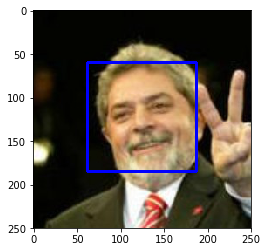

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[random.randint(0,len(human_files))])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
# Select subset of data for faster evaluation
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Vectorize the face dectector function
faces_vfunc = np.vectorize(face_detector)

# Detect faces in both sets
human_faces = faces_vfunc(human_files_short)
dog_faces = faces_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Faces detected in {:.2f}% of the sample human dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('Faces detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_faces)/len(dog_faces))*100))

Faces detected in 99.00% of the sample human dataset.
Faces detected in 12.00% of the sample dog dataset.


In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

img_width, img_height = 224, 224

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_width, img_height))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [10]:
# Files already loaded in previous cell 

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human_files_short)
dog_dogs = dog_vfunc(dog_files_short)

# Calculate and print percentage of faces in each set
print('Dogs detected in {:.2f}% of the sample human dataset.'.format((sum(human_dogs)/len(human_dogs))*100))
print('Dogs detected in {:.2f}% of the sample dog dataset.'.format((sum(dog_dogs)/len(dog_dogs))*100))

Dogs detected in 1.00% of the sample human dataset.
Dogs detected in 100.00% of the sample dog dataset.


In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:09<00:00, 84.46it/s]


In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

In [13]:
import numpy as np

### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.optimizers import Adam, Adamax
ResNet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

In [16]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_adamax.ResNet50.hdf5',verbose=1, save_best_only=True)

epochs = 30
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6400/6680 [===========================>..] - ETA: 1:14 - loss: 5.5025 - acc: 0.0000e+0 - ETA: 12s - loss: 5.5331 - acc: 0.0443    - ETA: 7s - loss: 5.1382 - acc: 0.0734 - ETA: 5s - loss: 4.8741 - acc: 0.090 - ETA: 4s - loss: 4.6310 - acc: 0.114 - ETA: 3s - loss: 4.4420 - acc: 0.137 - ETA: 3s - loss: 4.2808 - acc: 0.153 - ETA: 3s - loss: 4.1120 - acc: 0.179 - ETA: 2s - loss: 3.9672 - acc: 0.202 - ETA: 2s - loss: 3.8487 - acc: 0.221 - ETA: 2s - loss: 3.7056 - acc: 0.243 - ETA: 2s - loss: 3.5565 - acc: 0.266 - ETA: 1s - loss: 3.4620 - acc: 0.281 - ETA: 1s - loss: 3.3709 - acc: 0.299 - ETA: 1s - loss: 3.2872 - acc: 0.315 - ETA: 1s - loss: 3.2061 - acc: 0.331 - ETA: 1s - loss: 3.1351 - acc: 0.344 - ETA: 1s - loss: 3.0671 - acc: 0.358 - ETA: 1s - loss: 3.0026 - acc: 0.368 - ETA: 1s - loss: 2.9453 - acc: 0.379 - ETA: 0s - loss: 2.8889 - acc: 0.389 - ETA: 0s - loss: 2.8349 - acc: 0.401 - ETA: 0s - loss: 2.7802 - acc: 0.412 - ETA: 0s - l

6592/6680 [============================>.] - ETA: 1s - loss: 0.0920 - acc: 1.000 - ETA: 1s - loss: 0.0975 - acc: 0.992 - ETA: 1s - loss: 0.1081 - acc: 0.993 - ETA: 1s - loss: 0.0978 - acc: 0.995 - ETA: 1s - loss: 0.0952 - acc: 0.995 - ETA: 0s - loss: 0.0978 - acc: 0.995 - ETA: 0s - loss: 0.0978 - acc: 0.995 - ETA: 0s - loss: 0.0986 - acc: 0.993 - ETA: 0s - loss: 0.0969 - acc: 0.993 - ETA: 0s - loss: 0.0967 - acc: 0.993 - ETA: 0s - loss: 0.0965 - acc: 0.994 - ETA: 0s - loss: 0.0954 - acc: 0.994 - ETA: 0s - loss: 0.0955 - acc: 0.994 - ETA: 0s - loss: 0.0979 - acc: 0.994 - ETA: 0s - loss: 0.0975 - acc: 0.994 - ETA: 0s - loss: 0.0975 - acc: 0.994 - ETA: 0s - loss: 0.0981 - acc: 0.994 - ETA: 0s - loss: 0.0977 - acc: 0.994 - ETA: 0s - loss: 0.0971 - acc: 0.994 - ETA: 0s - loss: 0.0971 - acc: 0.995 - ETA: 0s - loss: 0.0970 - acc: 0.9950
Epoch 00011: val_loss improved from 0.56299 to 0.55014, saving model to saved_models/weights.best_adamax.ResNet50.hdf5
6680/6680 [============================

6592/6680 [============================>.] - ETA: 2s - loss: 0.0410 - acc: 0.984 - ETA: 1s - loss: 0.0301 - acc: 0.996 - ETA: 1s - loss: 0.0264 - acc: 0.997 - ETA: 1s - loss: 0.0245 - acc: 0.998 - ETA: 1s - loss: 0.0241 - acc: 0.998 - ETA: 1s - loss: 0.0233 - acc: 0.999 - ETA: 1s - loss: 0.0225 - acc: 0.999 - ETA: 1s - loss: 0.0225 - acc: 0.998 - ETA: 1s - loss: 0.0224 - acc: 0.998 - ETA: 1s - loss: 0.0222 - acc: 0.998 - ETA: 1s - loss: 0.0224 - acc: 0.999 - ETA: 1s - loss: 0.0224 - acc: 0.999 - ETA: 1s - loss: 0.0234 - acc: 0.998 - ETA: 1s - loss: 0.0235 - acc: 0.998 - ETA: 1s - loss: 0.0237 - acc: 0.999 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0242 - acc: 0.998 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0240 - acc: 0.998 - ETA: 0s - loss: 0.0239 - acc: 0.998 - ETA: 0s - loss: 0.0239 - acc: 0.998 - ETA: 0s - loss: 0.0242 - acc: 0.998 - ETA: 

In [17]:
opt = Adamax(lr=0.0002)
epochs = 5
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6592/6680 [============================>.] - ETA: 40s - loss: 0.0087 - acc: 1.00 - ETA: 7s - loss: 0.0086 - acc: 1.0000 - ETA: 5s - loss: 0.0087 - acc: 1.000 - ETA: 3s - loss: 0.0084 - acc: 1.000 - ETA: 2s - loss: 0.0107 - acc: 0.999 - ETA: 2s - loss: 0.0102 - acc: 0.999 - ETA: 2s - loss: 0.0097 - acc: 0.999 - ETA: 1s - loss: 0.0101 - acc: 0.999 - ETA: 1s - loss: 0.0105 - acc: 0.998 - ETA: 1s - loss: 0.0108 - acc: 0.998 - ETA: 1s - loss: 0.0108 - acc: 0.998 - ETA: 0s - loss: 0.0105 - acc: 0.998 - ETA: 0s - loss: 0.0104 - acc: 0.998 - ETA: 0s - loss: 0.0103 - acc: 0.999 - ETA: 0s - loss: 0.0103 - acc: 0.999 - ETA: 0s - loss: 0.0102 - acc: 0.999 - ETA: 0s - loss: 0.0101 - acc: 0.999 - ETA: 0s - loss: 0.0106 - acc: 0.998 - ETA: 0s - loss: 0.0105 - acc: 0.998 - ETA: 0s - loss: 0.0105 - acc: 0.998 - ETA: 0s - loss: 0.0105 - acc: 0.998 - ETA: 0s - loss: 0.0105 - acc: 0.9986
Epoch 00001: val_loss did not improve
6680/6680 [=============

In [18]:
### Load the model weights with the best validation loss.
ResNet_model.load_weights('saved_models/weights.best_adamax.ResNet50.hdf5')

In [19]:
# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.6124%


In [20]:
### This function takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    print(path_to_tensor(img_path).shape)
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return print("The breed of dog is a {}".format(breed))
    else:
        return print("If this person were a dog, the breed would be a {}".format(breed))

(1, 224, 224, 3)
The breed of dog is a Belgian_tervuren


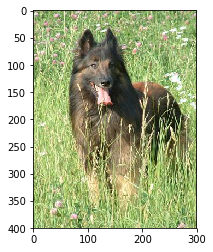

In [21]:
ResNet50_predict_breed('dogImages/test/022.Belgian_tervuren/Belgian_tervuren_01588.jpg')

In [22]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

def predict_breed(img_path):
    isDog = dog_detector(img_path)
    isPerson = face_detector(img_path)
    if isDog:
        print("Detected a dog")
        breed = ResNet50_predict_breed(img_path)
        return breed
    if isPerson:
        print("Detected a human face")
        breed = ResNet50_predict_breed(img_path)
        return breed
    else:
        print("No human face or dog detected")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)

Detected a dog
(1, 224, 224, 3)
The breed of dog is a French_bulldog


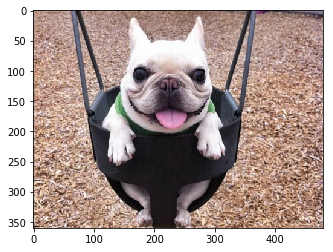

In [23]:
predict_breed('test/1.jpg')

In [24]:
from keras import backend as K
MODEL_NAME = 'dog_breed_cnn'
def export_model(saver, model, input_node_names, output_node_name):
    tf.train.write_graph(K.get_session().graph_def, 'out', \
        MODEL_NAME + '_graph.pbtxt')

    saver.save(K.get_session(), 'out/' + MODEL_NAME + '.chkp')

    freeze_graph.freeze_graph('out/' + MODEL_NAME + '_graph.pbtxt', None, \
        False, 'out/' + MODEL_NAME + '.chkp', output_node_name, \
        "save/restore_all", "save/Const:0", \
        'out/frozen_' + MODEL_NAME + '.pb', True, "")

    input_graph_def = tf.GraphDef()
    with tf.gfile.Open('out/frozen_' + MODEL_NAME + '.pb', "rb") as f:
        input_graph_def.ParseFromString(f.read())

    output_graph_def = optimize_for_inference_lib.optimize_for_inference(
            input_graph_def, input_node_names, [output_node_name],
            tf.float32.as_datatype_enum)

    with tf.gfile.FastGFile('out/opt_' + MODEL_NAME + '.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())


In [25]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
export_model(tf.train.Saver(), ResNet_model, ["global_average_pooling2d_1_input"], "dense_1/Softmax")

INFO:tensorflow:Restoring parameters from out/dog_breed_cnn.chkp
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.


In [62]:
gf = tf.GraphDef()
gf.ParseFromString(open('out/frozen_dog_breed_cnn.pb','rb').read())

In [63]:
[n.name + '=>' +  n.op for n in gf.node if n.op in ( 'Softmax','Placeholder')]

['global_average_pooling2d_1_input=>Placeholder', 'dense_1/Softmax=>Softmax']